<a href="https://colab.research.google.com/github/ankit-kothari/pytorch_approach_to_classification/blob/master/NLP_Part_6_Classification_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
data = pd.read_csv('/gdrive/My Drive/data/amazon_products.csv')
data = data.drop(columns=['Unnamed: 0'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58828 entries, 0 to 58827
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           58828 non-null  object
 1   clean_review     58828 non-null  object
 2   review_category  58828 non-null  object
 3   topic_category   58828 non-null  int64 
 4   topic_name       58828 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [ ]:
data['topic_name'].unique()

array(['books', 'video-quality', 'refund-and-return', 'movies', 'music',
       'games'], dtype=object)

In [ ]:
data['topic_name']=data['topic_name'].astype('category')
data['topic_name'].cat.categories
print(data['topic_name'].cat.categories)
data['topic_category_codes']=data['topic_name'].cat.codes.values
data = data.drop(columns=['review','review_category','topic_category','topic_name'])
data.head()

Index(['books', 'games', 'movies', 'music', 'refund-and-return',
       'video-quality'],
      dtype='object')


,clean_review,topic_category_codes
0,this self published book want know read paragr...,0
1,rather scratches insect droppings random pixel...,5
2,my experience got fm Amazon the dvd player rat...,5
3,ordered dvd received substitute received dvd o...,5
4,disappointed performance it underpowered const...,4


In [ ]:
data['topic_category_codes'].value_counts()

4    23020
0    16273
3     7768
5     5203
2     4855
1     1709
Name: topic_category_codes, dtype: int64

In [ ]:
data.to_csv('/gdrive/My Drive/data/pytorch_amazon_products.csv')

In [ ]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    tokenize='spacy',
    pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True,batch_first=True)

In [ ]:
dataset = ttd.TabularDataset(
    path='/gdrive/My Drive/data/pytorch_amazon_products.csv',
    format='csv',
    skip_header=True,
    fields=[(None,None),('data', TEXT), ('label', LABEL)]
)

In [ ]:
import random
train_dataset, test_dataset = dataset.split(split_ratio=0.7)

In [ ]:
print(vars(train_dataset.examples[0]))

{'data': ['and', 'exactly', 'tale', 'it', 'adventure', 'ring', 'true', 'found', 'later', 'jones', 'biographer', 'wrote', 'numerous', 'instances', 'tristan', 'twisted', 'truth', 'nonetheless', 'fun', 'read', 'stars', 'you', 'buy', 'copy', 'bill', 'books', 'Amazon', 'marketplace', 'judge'], 'label': '0'}


In [ ]:
print(vars(train_dataset[1]))

{'data': ['joel', 'kasow', 'gave', 'disc', 'neutral', 'review', 'fanfare', 'finding', 'small', 'faults', 'style', 'soloists', 'notes', 'for', 'complete', 'selections', 'male', 'choruses', 'suggests', 'cd', 'soloist', 'collection', 'sawallisch', 'emi', 'cd', 'medium', 'sized', 'group', 'collection', 'ortner', 'teldec', 'for', 'single', 'dic', 'sample', 'love', 'knothe', 'rendition', 'small', 'groups', 'including', 'songs', 'women', 'chorus', 'capriccio', 'time', 'favorite', 'cds', 'germanic', 'early', 'romantic', 'singing', 'varied', 'dynamic', 'schubert', 'program', 'absolutely', 'luscious', 'however', 'find', 'Amazon'], 'label': '3'}


In [ ]:
#initialize glove embeddings
TEXT.build_vocab(train_dataset,min_freq=4, max_size=24998)  

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
#print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)  

Size of TEXT vocabulary: 20782
[('Amazon', 48903), ('the', 25036), ('book', 24193), ('it', 15324), ('this', 13683), ('like', 11816), ('bought', 9255), ('time', 8826), ('dvd', 8546), ('movie', 8475)]
defaultdict(<function _default_unk_index at 0x7fd2675c3730>, {'<unk>': 0, '<pad>': 1, 'Amazon': 2, 'the': 3, 'book': 4, 'it': 5, 'this': 6, 'like': 7, 'bought': 8, 'time': 9, 'dvd': 10, 'movie': 11, 'cd': 12, 'item': 13, 'buy': 14, 'don': 15, 'read': 16, 'good': 17, 'new': 18, 'great': 19, 'reviews': 20, 'use': 21, 'got': 22, 'work': 23, 'if': 24, 'purchased': 25, 'find': 26, 'com': 27, 've': 28, 'books': 29, 'know': 30, 'better': 31, 'return': 32, 'version': 33, 'found': 34, 'way': 35, 'money': 36, 'didn': 37, 'years': 38, 'review': 39, 'my': 40, 'think': 41, 'love': 42, 'not': 43, 'ordered': 44, 'want': 45, 'old': 46, 'product': 47, 'music': 48, 'but': 49, 'so': 50, 'little': 51, 'received': 52, 'purchase': 53, 'album': 54, 'problem': 55, 'bad': 56, 'reading': 57, 'people': 58, 'quality':

In [ ]:
vocab = TEXT.vocab

In [ ]:
len(vocab)

20782

In [ ]:
word2idx =TEXT.vocab.stoi

In [ ]:
type(word2idx)

collections.defaultdict

In [ ]:
# load in pre-trained word vectors
EMBEDDING_DIM=50
MAX_VOCAB_SIZE=25000
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/gdrive/My Drive/data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    value = np.asarray(values[1:] , dtype='float32')
    word2vec[word]=value
print(len(word2vec))

Loading word vectors...
400000


In [ ]:
word2vec['<unk>']=word2vec['unk']
word2vec['<pad>']=word2vec['pad']

In [ ]:
rem_list=['unk','pad']

In [ ]:
[word2vec.pop(key) for key in rem_list]

[array([-7.9149e-01,  8.6617e-01,  1.1998e-01,  9.2287e-04,  2.7760e-01,
        -4.9185e-01,  5.0195e-01,  6.0792e-04, -2.5845e-01,  1.7865e-01,
         2.5350e-01,  7.6572e-01,  5.0664e-01,  4.0250e-01, -2.1388e-03,
        -2.8397e-01, -5.0324e-01,  3.0449e-01,  5.1779e-01,  1.5090e-02,
        -3.5031e-01, -1.1278e+00,  3.3253e-01, -3.5250e-01,  4.1326e-02,
         1.0863e+00,  3.3910e-02,  3.3564e-01,  4.9745e-01, -7.0131e-02,
        -1.2192e+00, -4.8512e-01, -3.8512e-02, -1.3554e-01, -1.6380e-01,
         5.2321e-01, -3.1318e-01, -1.6550e-01,  1.1909e-01, -1.5115e-01,
        -1.5621e-01, -6.2655e-01, -6.2336e-01, -4.2150e-01,  4.1873e-01,
        -9.2472e-01,  1.1049e+00, -2.9996e-01, -6.3003e-03,  3.9540e-01],
       dtype=float32),
 array([ 0.15728 , -0.55574 ,  0.72423 ,  0.23084 , -0.31139 , -0.3413  ,
        -0.07583 , -0.54296 ,  0.1319  ,  0.1219  , -0.078471, -0.12752 ,
         0.38156 ,  1.2938  , -0.80035 ,  0.56079 , -0.60463 , -0.083568,
        -0.71688 , -0.02

In [ ]:
# prepare embedding matrix
#print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word,i in word2idx.items():
  #print(word)
  #print(i)
  if i < MAX_VOCAB_SIZE:
    embedding_vector= word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i]=embedding_vector
embedding_matrix=torch.tensor(embedding_matrix, dtype=float)
print(type(embedding_matrix))
print(embedding_matrix.shape)

<class 'torch.Tensor'>
torch.Size([20782, 50])


In [ ]:
embedding_matrix[7]

tensor([ 3.6808e-01,  2.0834e-01, -2.2319e-01,  4.6283e-02,  2.0098e-01,
         2.7515e-01, -7.7127e-01, -7.6804e-01, -3.4861e-01,  5.0620e-01,
        -2.4401e-01,  7.1775e-01, -3.3348e-01,  3.7554e-01,  4.4756e-01,
         3.6698e-01,  4.3533e-01,  4.7570e-01, -5.6113e-02, -9.3531e-01,
        -2.7591e-01,  3.1610e-01,  2.2116e-01,  3.6304e-01,  1.0757e-01,
        -1.7638e+00, -1.2624e+00,  3.0284e-01,  5.6286e-01, -1.0214e+00,
         3.2353e+00,  4.8483e-01,  2.7953e-02,  3.6082e-02, -7.8554e-02,
         1.8761e-01, -5.2573e-01,  3.7200e-02,  2.7579e-01, -7.7360e-02,
        -2.7955e-01,  7.9752e-01,  1.6028e-03,  4.5479e-01,  8.8382e-01,
         4.3893e-01, -1.9263e-01, -6.7236e-01, -3.9709e-01,  2.5183e-01],
       dtype=torch.float64)

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    vocab_size, embedding_dim = embedding_matrix.shape
    emb_layer = nn.Embedding(vocab_size, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#BATCH_SIZE = 64
#train_iter, test_iter = ttd.Iterator.splits(
#        (train_dataset, test_dataset), sort_key=lambda x: len(x.data),
#        batch_sizes=(32, 256), device=device)


train_iter, test_iter = ttd.BucketIterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data),
    sort_within_batch=True,
    batch_sizes=(128, 256),
    device = device)

In [ ]:
print(len(train_iter))

322


In [ ]:
for inputs, targets in train_iter:
  print("inputs shape:", inputs.shape)
  print("targets shape:", targets.shape)
  break

inputs shape: torch.Size([128, 38])
targets shape: torch.Size([128])


In [ ]:
for inputs, targets in test_iter:
  print("inputs:", inputs.shape)
  print("targets:", targets.shape)
  break

inputs: torch.Size([256, 10])
targets: torch.Size([256])


In [ ]:
# Things you should automatically know and have memorized
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hidden units
# K = number of output units

class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, weights_matrix):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers
    self.dropout1 = nn.Dropout(0.5)
    self.embedding_matrix = weights_matrix
    self.embed = nn.Embedding(self.V, self.D,    
                         _weight=self.embedding_matrix)

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size= self.M,
        num_layers = self.L,
        batch_first = True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out = self.embed(X)
    #print(f'embedding shape {out.shape}')
    out = out.float()
    out, _ = self.rnn(out,(h0,c0) )
    out = F.relu(out)
    #print(f'LSTM out shape {out.shape}')
    # max pool
    drop = self.dropout1(out)
    out, _ = torch.max(drop, 1)
    out = F.relu(out)
    #print(f'MAXPOOL out shape {out.shape}')
    #we only want h(T) at the final time step
    out = self.dropout1(out)
    #print(f'Dropout shape {out.shape}')
    out = self.fc(out)
    #print(f'Dense out shape {out.shape}')
    return out


In [ ]:
model = RNN(len(vocab), 50, 128, 2, 6, embedding_matrix)
model.to(device)

RNN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (embed): Embedding(20782, 50)
  (rnn): LSTM(50, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
total_param  = []
for p in model.parameters():
    total_param.append(int(p.numel()))

In [ ]:
X = np.random.randint(5, size=(2, 4))
inputs = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
inputs

tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])

In [ ]:
model(inputs.to(device))

tensor([[ 0.0209, -0.0737, -0.0733,  0.0667, -0.0779,  0.0125],
        [ 0.0893, -0.0498, -0.0257,  0.0325,  0.0041, -0.0428]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
epochs = 10
best_valid_loss = float('inf')
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
start_time=time.time()
for e in range(epochs):
  t0 = time.time()
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  total_inputs= 0.0
  total_test_inputs=0.0
  for inputs, labels in train_iter:
    #print(len(inputs))
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    total_inputs += len(inputs)
    
    #print(f' corrects {torch.sum(preds == labels.data)}')
    running_corrects += torch.sum(preds == labels.data)
  
  
  else:
    with torch.no_grad():
      for val_inputs, val_labels in test_iter:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        total_test_inputs += len(val_inputs)
        
      
      if val_running_loss < best_valid_loss:
          best_valid_loss=val_running_loss
          model_name='/gdrive/My Drive/models/pytorch_amazon_classification.pt'
          torch.save(model.state_dict(), model_name)
          print(f'Epoch {e} model saved at {val_loss:.2f}' )
    
 
  print(f'Epoch {e}  {time.time() - t0:.0f}  Train_loss: {running_loss/len(train_iter):.4f} Train_acc: {(running_corrects/total_inputs)*100:.4f} val_loss: {val_running_loss/len(test_iter):.4f} val_accuracy: {(val_running_corrects/total_test_inputs)*100:.4f}')
  val_running_loss_history.append(val_running_loss/len(test_iter))
  running_loss_history.append(running_loss/len(train_iter))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

Epoch 0 model saved at 0.26
Epoch 0  4  Train_loss: 0.5653 Train_acc: 81.8334 val_loss: 0.2325 val_accuracy: 93.0870
Epoch 1 model saved at 0.19
Epoch 1  3  Train_loss: 0.1796 Train_acc: 94.3006 val_loss: 0.1684 val_accuracy: 94.5206
Epoch 2 model saved at 0.19
Epoch 2  4  Train_loss: 0.1308 Train_acc: 95.7625 val_loss: 0.1433 val_accuracy: 95.4896
Epoch 3 model saved at 0.20
Epoch 3  4  Train_loss: 0.1107 Train_acc: 96.3137 val_loss: 0.1314 val_accuracy: 95.8069
Epoch 4  3  Train_loss: 0.0960 Train_acc: 96.8286 val_loss: 0.1334 val_accuracy: 95.7786
Epoch 5  4  Train_loss: 0.0818 Train_acc: 97.3677 val_loss: 0.1493 val_accuracy: 95.4272
Epoch 6  4  Train_loss: 0.0697 Train_acc: 97.7222 val_loss: 0.1492 val_accuracy: 95.5632
Epoch 7  3  Train_loss: 0.0606 Train_acc: 98.0962 val_loss: 0.1582 val_accuracy: 95.4386
Epoch 8  3  Train_loss: 0.0501 Train_acc: 98.4094 val_loss: 0.1762 val_accuracy: 95.4726
Epoch 9  3  Train_loss: 0.0453 Train_acc: 98.5891 val_loss: 0.1584 val_accuracy: 95.636

In [ ]:
running_loss_history

[0.5652775702917058,
 0.17964779701292144,
 0.1308401056004237,
 0.11072331899487824,
 0.09600391206534012,
 0.08176499737646453,
 0.06972224253189305,
 0.06062820110967533,
 0.050116236628212546,
 0.04532498639273625]

In [ ]:
val_running_loss_history

[0.23252072617195654,
 0.16843769353800925,
 0.14331624570532123,
 0.1313542852151221,
 0.13340250386492067,
 0.14928680949884912,
 0.14921716579060623,
 0.15820448338121607,
 0.1762267647014148,
 0.1583901868350264]

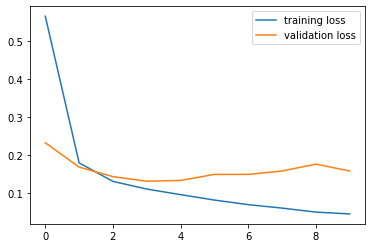

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
len(test_iter)

69

In [ ]:
path='/gdrive/My Drive/models/pytorch_amazon_classification.pt'
model.load_state_dict(torch.load(path));
model.eval()



RNN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (embed): Embedding(20782, 50)
  (rnn): LSTM(50, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    print(sentence)
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    print(tokenized)
    indexed = np.array([TEXT.vocab.stoi[t] for t in tokenized])      #convert to integer sequence
    print(indexed)
    length = len(indexed)                                    #compute no. of words
    print(indexed)
    tensor = torch.LongTensor(indexed).to(device)  
    tensor = tensor.unsqueeze(1)  
    print(torch.Size(tensor))
    tensor = tensor.view(-1, len(tensor))     #convert to tensor
                             #reshape in form of batch,no. of words
                   #convert to tensor
    prediction = model(tensor.to(device))                  #prediction 
    return torch.max(prediction,1) 

In [ ]:
predict(model, "I like the movie titanic which is shown on prime")


I like the movie titanic which is shown on prime
['I', 'like', 'the', 'movie', 'titanic', 'which', 'is', 'shown', 'on', 'prime']
[   0    7    3   11 7569 1784  455  693  313  775]
[   0    7    3   11 7569 1784  455  693  313  775]
torch.Size([0, 7, 3, 11, 7569, 1784, 455, 693, 313, 775])


torch.return_types.max(values=tensor([2.5408], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([2], device='cuda:0'))

In [ ]:
predict(model, "that was a wondeful  written content by my best author gave me a lot of insights in life. It had a lot of meaing to it.")


that was a wondeful  written content by my best author gave me a lot of insights in life. It had a lot of meaing to it.
['that', 'was', 'a', 'wondeful', ' ', 'written', 'content', 'by', 'my', 'best', 'author', 'gave', 'me', 'a', 'lot', 'of', 'insights', 'in', 'life', '.', 'It', 'had', 'a', 'lot', 'of', 'meaing', 'to', 'it', '.']
[ 144  860 1682    0    0  174  436  771   40   62  141  184 1002 1682
  102  429 3276   92  189    0    0  910 1682  102  429    0  277    5
    0]
[ 144  860 1682    0    0  174  436  771   40   62  141  184 1002 1682
  102  429 3276   92  189    0    0  910 1682  102  429    0  277    5
    0]
torch.Size([144, 860, 1682, 0, 0, 174, 436, 771, 40, 62, 141, 184, 1002, 1682, 102, 429, 3276, 92, 189, 0, 0, 910, 1682, 102, 429, 0, 277, 5, 0])


torch.return_types.max(values=tensor([1.0335], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

In [ ]:
predict(model, "that was a wondeful  movie but the songs were pathetic.")


that was a wondeful  movie but the songs were pathetic.
['that', 'was', 'a', 'wondeful', ' ', 'movie', 'but', 'the', 'songs', 'were', 'pathetic', '.']
[ 144  860 1682    0    0   11   49    3   99 4825 2517    0]
[ 144  860 1682    0    0   11   49    3   99 4825 2517    0]
torch.Size([144, 860, 1682, 0, 0, 11, 49, 3, 99, 4825, 2517, 0])


torch.return_types.max(values=tensor([2.4996], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([2], device='cuda:0'))

In [ ]:
predict(model, "the songs were great but the movie was pathetic.")


the songs were great but the movie was pathetic.
['the', 'songs', 'were', 'great', 'but', 'the', 'movie', 'was', 'pathetic', '.']
[   3   99 4825   19   49    3   11  860 2517    0]
[   3   99 4825   19   49    3   11  860 2517    0]
torch.Size([3, 99, 4825, 19, 49, 3, 11, 860, 2517, 0])


torch.return_types.max(values=tensor([1.6832], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([2], device='cuda:0'))